# Comparison: Year 2023, v202111, to Climatology

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [84]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]
mesh_mask_depth_var='gdept_0'
thalweg_file = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'

In [3]:
year = '2023'
year2 = '23'
imonth = '07'
month = 'jul'
sday = 9
eday = 23
newdir = '/results2/SalishSea/nowcast-green.202111/'

In [165]:
def surface_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, twoD=False, zoom=[0, 0, 0, 0], 
                  dl=0, dosum=False, new=False, surface_mask=False):
    fig, axs = plt.subplots(1, 4, figsize=(20, 7))
    fig.suptitle(f'{tracer}', fontsize=18)

    if new:
        for tyear in ['07', '08', '09', '10', '11', '12', '13', '14',  
                      '15', '16', '17', '18', '19', '20', '21', '22']:
            print (tyear)
            ayear = f'20{tyear}'
            for day in range(sday,eday+1,1):
                dm = xr.open_dataset(
                    f'{newdir}/{day:02d}{month}{tyear}/SalishSea_1d_{ayear}{imonth}{day:02d}_{ayear}{imonth}{day:02d}_{file}_T.nc')
                
                if twoD:
                    new_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
                else:
                    if dosum:
                        if surface_mask:
                            new_field = np.ma.array(dm[tracer][0, 0:dl].sum(axis=0), mask=1-tmask[0, 0])
                        else:
                            new_field = np.ma.array(dm[tracer][0, 0:dl].sum(axis=0), mask=1-tmask[0, dl])
                    else:
                        new_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
    
                if day == sday:
                    mean_field_yr = new_field
                    count = 1
                else:
                    mean_field_yr = mean_field_yr + new_field
                    count = count + 1
            if  tyear == '07':
                mean_field = mean_field_yr
                squared = mean_field_yr * mean_field_yr
                ycount = 1
            else:
                mean_field = mean_field + mean_field_yr
                squared = squared + mean_field_yr * mean_field_yr
                ycount = ycount + 1
                    
        
                dm.close()
    
        mean_field = mean_field/(ycount*count)
        stdev = np.ma.sqrt(squared/(ycount*count**2) - mean_field * mean_field)
        print (stdev.max(), count, ycount)
        np.savetxt(f'Mean_{tracer}_climatology_from2007_2022_{month}_{sday}to{eday}.csv', mean_field)
        np.savetxt(f'Stdev_{tracer}_climatology_from2007_2022_{month}_{sday}to{eday}.csv', stdev)
    else:
        tempA = np.loadtxt(f'Mean_{tracer}_climatology_from2007_2022_{month}_{sday}to{eday}.csv')       
        tempB = np.loadtxt(f'Stdev_{tracer}_climatology_from2007_2022_{month}_{sday}to{eday}.csv')
        if surface_mask:
            mean_field = np.ma.array(tempA, mask=1-tmask[0, 0])
            stdev = np.ma.array(tempB, mask=1-tmask[0, 0])
        else:
            mean_field = np.ma.array(tempA, mask=1-tmask[0, dl])
            stdev = np.ma.array(tempB, mask=1-tmask[0, dl])
        
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title("Climatology")
    fig.colorbar(colours, ax=axs[0])

    if new:
        for day in range(sday,eday+1,1):
            print (day)
            ds = xr.open_dataset(
                f'{newdir}/{day:02d}{month}{year2}/SalishSea_1h_{year}{imonth}{day:02d}_{year}{imonth}{day:02d}_{file}_T.nc')
            if twoD:
                new_field = np.ma.array(ds[tracer][:].mean(axis=0), mask=1-tmask[0, 0])
            else:
                if dosum:
                    if surface_mask:
                        new_field = np.ma.array(ds[tracer][:, 0:dl].sum(axis=1).mean(axis=0), mask=1-tmask[0, 0])
                    else:
                        new_field = np.ma.array(ds[tracer][:, 0:dl].sum(axis=1).mean(axis=0), mask=1-tmask[0, dl])
                else:
                    new_field = np.ma.array(ds[tracer][:, dl].mean(axis=0), mask=1-tmask[0, dl])
                          
            if (day == sday):
                field = new_field
                count = 1
            else:
                field = field + new_field
                count = count + 1
            ds.close()
    
        field = field/count
        np.savetxt(f'Mean_{tracer}_{year}_{month}_{sday}to{eday}.csv', field)
    else:
        temp = np.loadtxt(f'Mean_{tracer}_{year}_{month}_{sday}to{eday}.csv')
        if surface_mask:
            field = np.ma.array(temp, mask=1-tmask[0, 0])
        else:
            field = np.ma.array(temp, mask=1-tmask[0, dl])
                      
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title('2023')
    fig.colorbar(colours, ax=axs[1])

    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("2023 - Climatology")
    fig.colorbar(colours, ax=axs[2])

#    colours = axs[3].pcolormesh(stdev, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
#    axs[3].set_title("Standard Deviation")
    colours = axs[3].pcolormesh((field-mean_field)/(stdev+0.0001), cmap=cm.oxy, vmax=3.3, vmin=-3.3)
    axs[3].set_title("Anomaly / Standard Deviation")
    fig.colorbar(colours, ax=axs[3])

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig
    

In [168]:
def thalweg_plot_n_save(tracers, file, cmap, cdiff, vmax, vmin, dvmax, maxdepth=0, dosum=False, new=False):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{tracer}', fontsize=18)
    step = (vmax-vmin)/10.
    thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)

    if new:

        for tyear in ['07', '08', '09', '10', '11', '12', '13', '14',  
                      '15', '16', '17', '18', '19', '20', '21', '22']:
            print (tyear)
            ayear = f'20{tyear}'
            for day in range(sday,eday+1,1):
                dm = xr.open_dataset(
                    f'{newdir}/{day:02d}{month}{tyear}/SalishSea_1d_{ayear}{imonth}{day:02d}_{ayear}{imonth}{day:02d}_{file}_T.nc')
                
                new_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    
                if day == sday:
                    mean_field_yr = new_field
                    count = 1
                else:
                    mean_field_yr = mean_field_yr + new_field
                    count = count + 1
            
            if  tyear == '07':
                mean_field = mean_field_yr
                squared = mean_field_yr * mean_field_yr
                ycount = 1
            else:
                mean_field = mean_field + mean_field_yr
                squared = squared + mean_field_yr * mean_field_yr
                ycount = ycount + 1
                    
        
                dm.close()
    
        mean_field = mean_field/(ycount*count)
        stdev = np.ma.sqrt(squared/(ycount*count**2) - mean_field * mean_field)
        print (stdev.max(), count, ycount)

        depth = mesh.variables[mesh_mask_depth_var][:]
        dep_thal, distance, var_thal = vis.load_thalweg(
            depth[0, ...], mean_field, bathy['nav_lon'][:], bathy['nav_lat'][:],
            thalweg_pts)

        np.savetxt(f'Thalweg_Mean_{tracer}_climatology_from2007_2022_{month}_{sday}to{eday}.csv', var_thal)
        np.savetxt(f'Thalweg_Distance.csv', distance)
        np.savetxt(f'Thalweg_Depth.csv', dep_thal)

    else:
        var_thal = np.loadtxt(f'Thalweg_Mean_{tracer}_climatology_from2007_2022_{month}_{sday}to{eday}.csv')
        distance = np.loadtxt(f'Thalweg_Distance.csv')
        dep_thal = np.loadtxt(f'Thalweg_Depth.csv')

    var_plot = vis._fill_in_bathy(var_thal, mesh, thalweg_pts)

    colours = axs[0, 0].contourf(distance, dep_thal, var_plot, np.arange(vmin,vmax+step, step), 
                                 cmap=cmap, extend='both')
    vis._add_bathy_patch(
        distance, bathy['Bathymetry'][:], thalweg_pts, axs[0, 0], color='burlywood')
    cbar = fig.colorbar(colours, ax=axs[0, 0])
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_ylabel('Depth [m]')
    axs[0, 0].set_title('Climatology')

    if new:
    
        for day in range(sday,eday+1,1):
            print (day)
            ds = xr.open_dataset(
                f'{newdir}/{day:02d}{month}{year2}/SalishSea_1h_{year}{imonth}{day:02d}_{year}{imonth}{day:02d}_{file}_T.nc')
          
            new_field = np.ma.array(ds[tracer][:].mean(axis=0), mask=1-tmask[0])
            
            if (day == sday):
                field = new_field
                count = 1
            else:
                field = field + new_field
                count = count + 1
            ds.close()
    
        field = field/count

        dep_thal, distance, var_thal2 = vis.load_thalweg(
            depth[0, ...], field, bathy['nav_lon'][:], bathy['nav_lat'][:],
            thalweg_pts)

        np.savetxt(f'Thalweg_Mean_{tracer}_{year}_{month}_{sday}to{eday}.csv', var_thal2)

        dep_thal, distance, anom = vis.load_thalweg(
            depth[0, ...], (field-mean_field)/(stdev+0.001), bathy['nav_lon'][:], bathy['nav_lat'][:],
            thalweg_pts)

        np.savetxt(f'Thalweg_Anom_{tracer}_{year}_{month}_{sday}to{eday}.csv', anom)
    else:
        var_thal2 = np.loadtxt(f'Thalweg_Mean_{tracer}_{year}_{month}_{sday}to{eday}.csv')
        anom = np.loadtxt(f'Thalweg_Anom_{tracer}_{year}_{month}_{sday}to{eday}.csv')

    var_plot = vis._fill_in_bathy(var_thal2, mesh, thalweg_pts)

    colours = axs[0, 1].contourf(distance, dep_thal, var_plot, np.arange(vmin,vmax+step, step), 
                                 cmap=cmap, extend='both')
    vis._add_bathy_patch(
        distance, bathy['Bathymetry'][:], thalweg_pts, axs[0, 1], color='burlywood')
    cbar = fig.colorbar(colours, ax=axs[0, 1])
    axs[0, 1].invert_yaxis()
    axs[0, 1].set_ylabel('Depth [m]')
    axs[0, 1].set_title('2023')

    var_plot = vis._fill_in_bathy(var_thal2 - var_thal, mesh, thalweg_pts)

    colours = axs[1, 0].contourf(distance, dep_thal, var_plot, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                 cmap=cdiff, extend='both')
    vis._add_bathy_patch(
        distance, bathy['Bathymetry'][:], thalweg_pts, axs[1, 0], color='burlywood')
    cbar = fig.colorbar(colours, ax=axs[1, 0])
    axs[1, 0].invert_yaxis()
    axs[1, 0].set_ylabel('Depth [m]')
    axs[1, 0].set_title("2023 - Climatology")

    var_plot = vis._fill_in_bathy(anom, mesh, thalweg_pts)

    colours = axs[1, 1].contourf(distance, dep_thal, var_plot, np.arange(-3.5, 3.5+0.5, 0.5), 
                                 cmap=cm.oxy, extend='both')
    vis._add_bathy_patch(
        distance, bathy['Bathymetry'][:], thalweg_pts, axs[1, 1], color='burlywood')
    cbar = fig.colorbar(colours, ax=axs[1, 1])
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylabel('Depth [m]')
    axs[1, 1].set_title("Anomaly / Standard Deviation")

    if maxdepth > 0:
        for ax in axs.flatten():
            ax.set_ylim(maxdepth, 0)

    fig.tight_layout()
    return fig

### Temperature ###

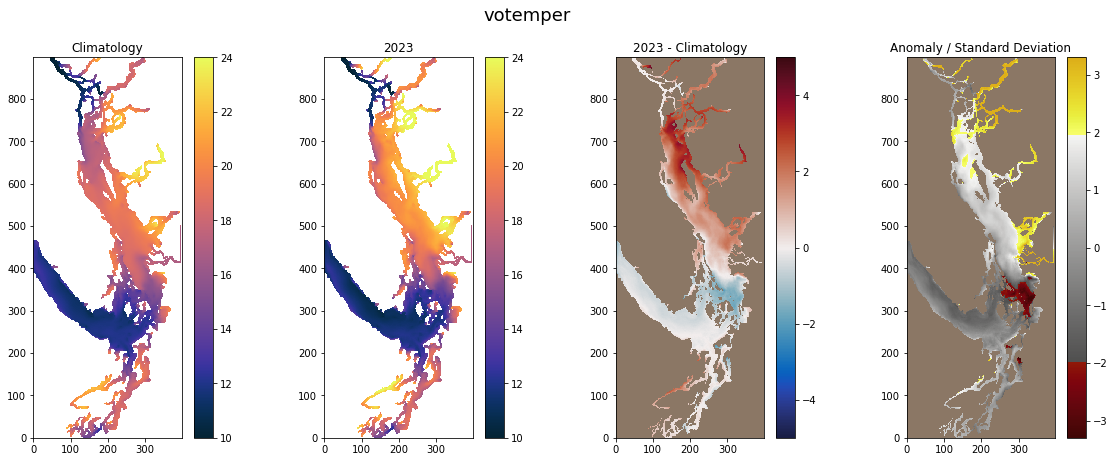

In [166]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cdiff = cm.balance
vmax = 24
vmin = 10
dvmax = 5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

The northern and central SoG were warm and the southern SoG cold.  The temperature in the inlets and the southern SoG was extreme.

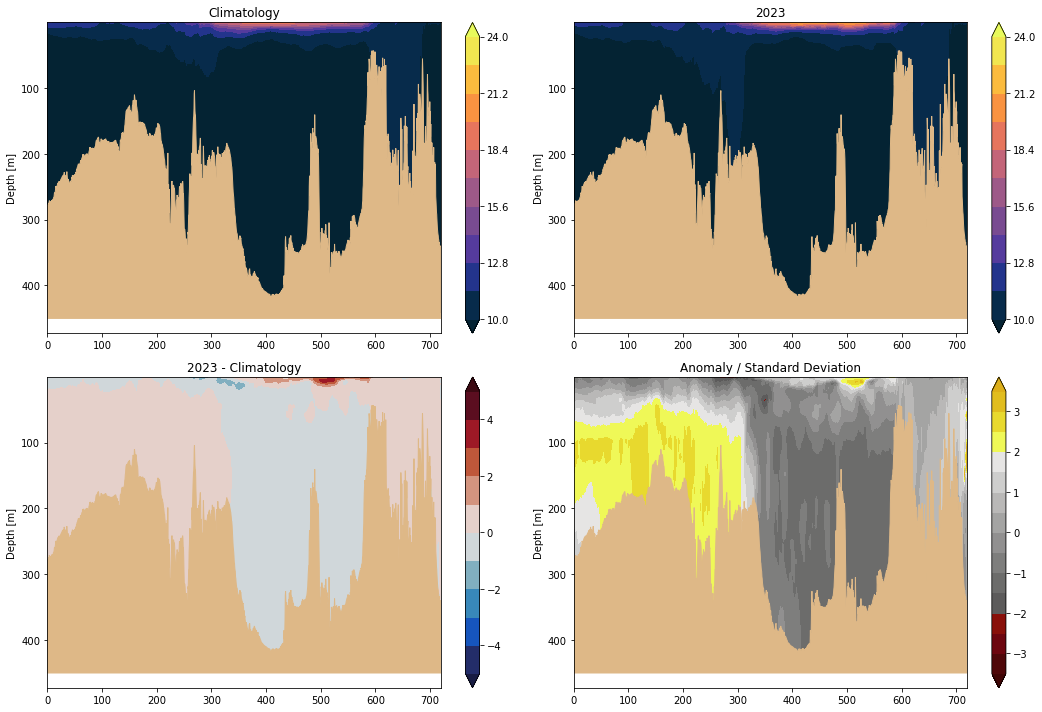

In [134]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cdiff = cm.balance
vmax = 24
vmin = 10
dvmax = 5
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

Along the thalweg we can see that the north SoG is extremely warm through the top 20 m and that the incoming boundary tempeature is also very warm.

### Salinity ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
4.738922 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


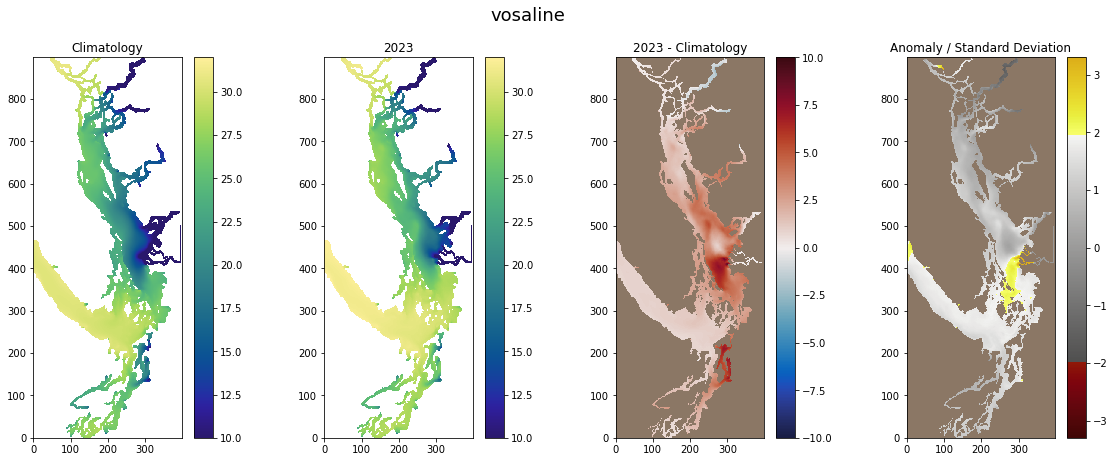

In [167]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 10
dvmax = 10
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

Surface waters are salty. In the southern SoG and Boundary Pass the conditions are extreme.

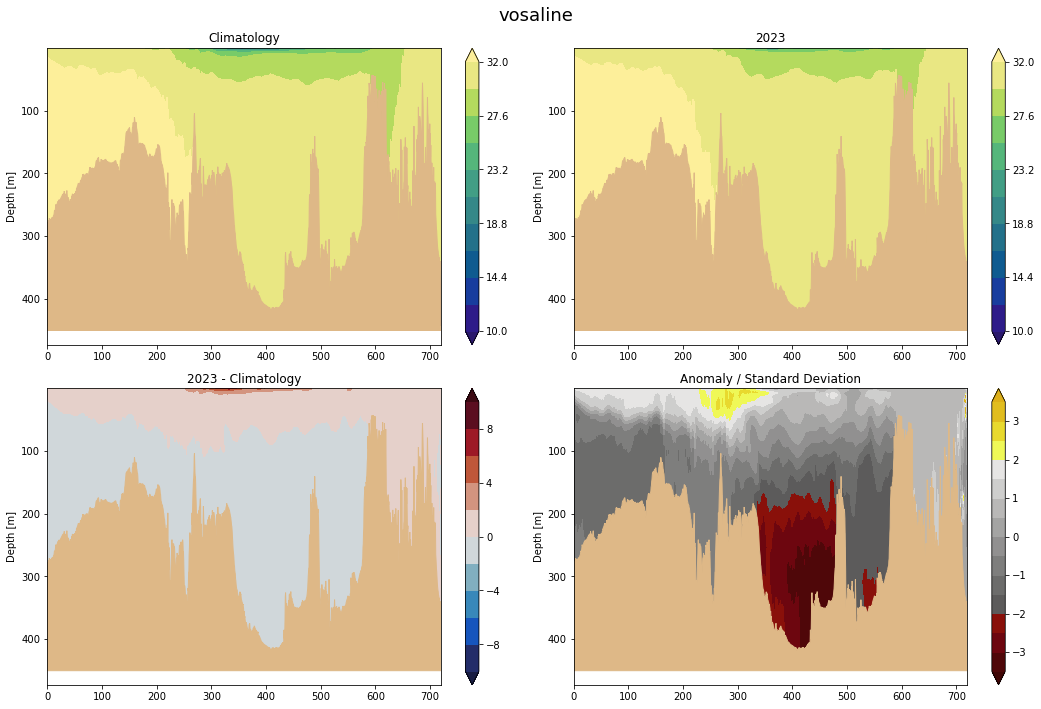

In [169]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 10
dvmax = 10
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

Clear on the thalweg that the salty SoG and Boundary Pass extends down to 50 m.  Deep SoG is unseasonally fresh.

### Sea Surface Height ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
1.6446571 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


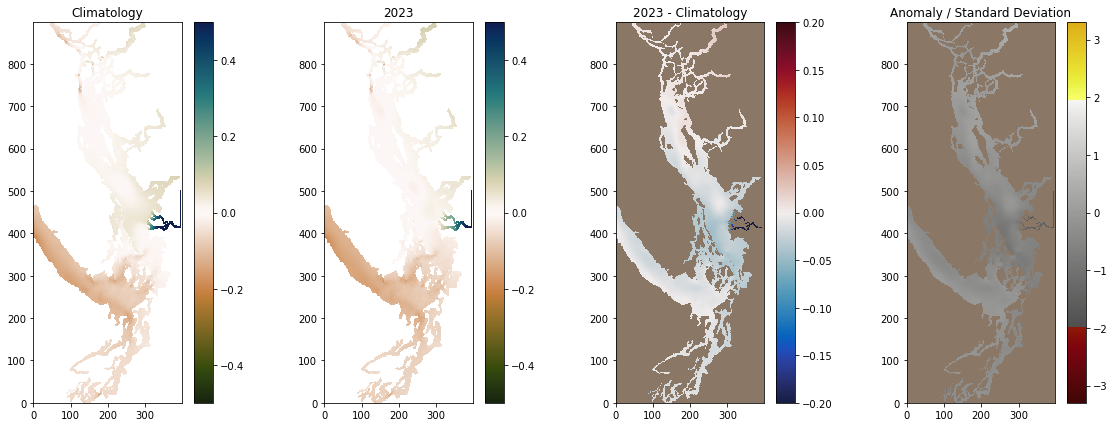

In [45]:
tracer = 'sossheig'
file = 'grid'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, twoD=True)

SSH is low consistent with low freshwater flux.

### Nitrate ###

07
08
09
10
11
12
13
18
19
20
21
22
23


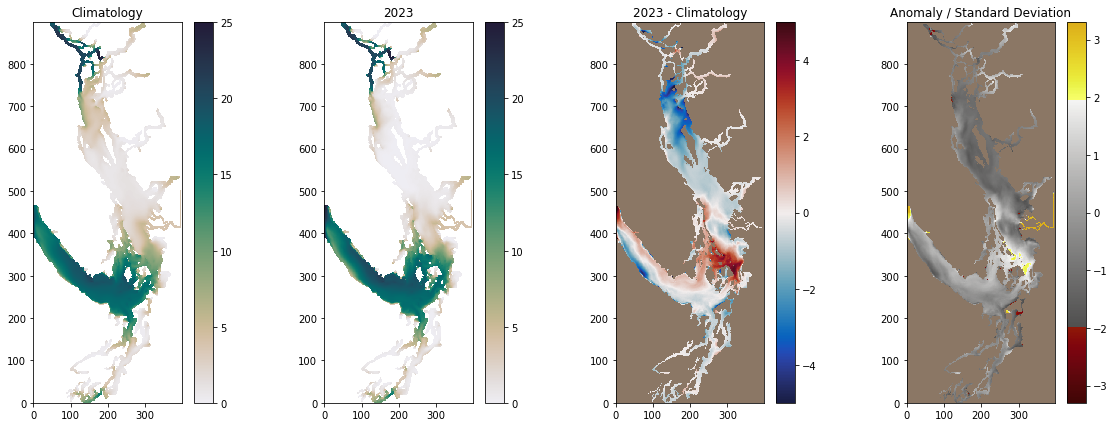

In [46]:
tracer = 'nitrate'
file = 'biol'
cmap = cm.rain
cdiff = cm.balance
vmax = 25
vmin = 0
dvmax = 5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

Nitrate is low in the central and northern SoG and high in southern SoG, Boundary Pass and Haro Strait.  Only extreme in southern SoG.

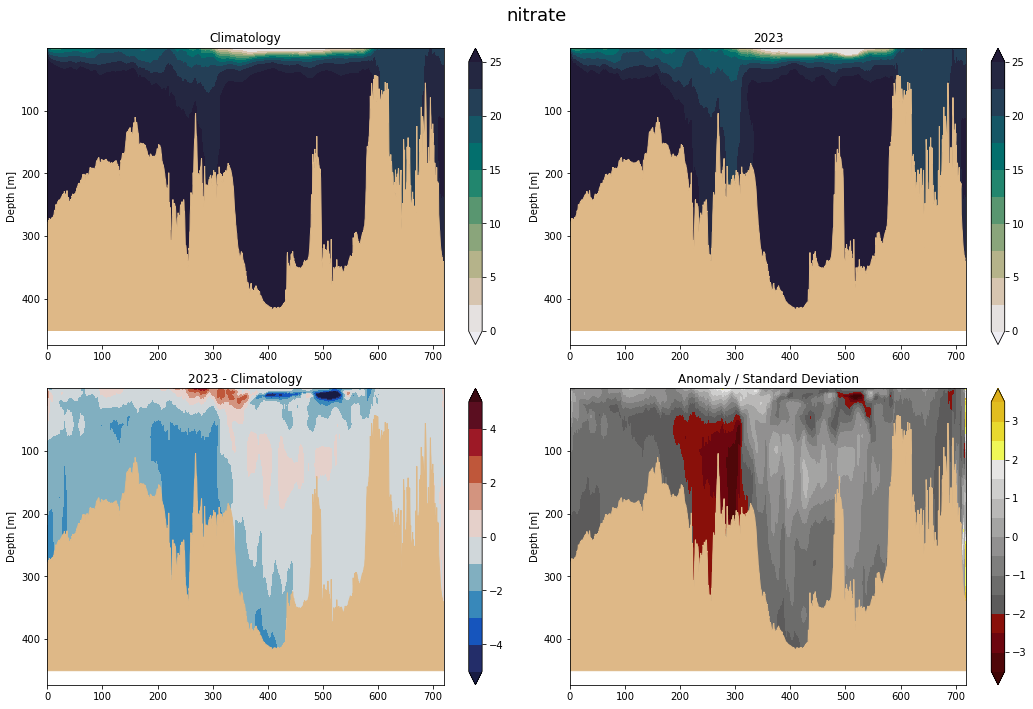

In [170]:
tracer = 'nitrate'
file = 'biol'
cmap = cm.rain
cdiff = cm.balance
vmax = 25
vmin = 0
dvmax = 5
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

Low nitrate in northern SoG and in deep boundary pass region.

### NH4 ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
0.70997065 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


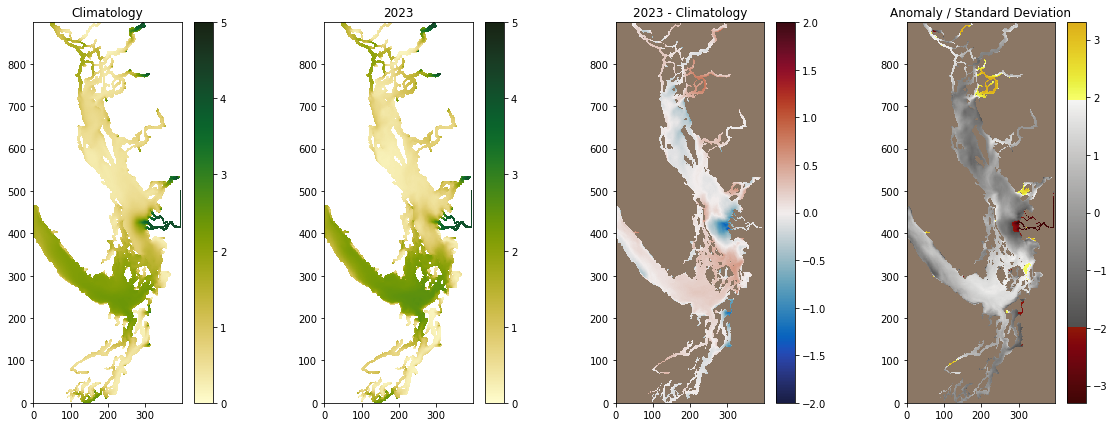

In [48]:
tracer = 'ammonium'
file = 'biol'
cmap = cm.speed
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, )

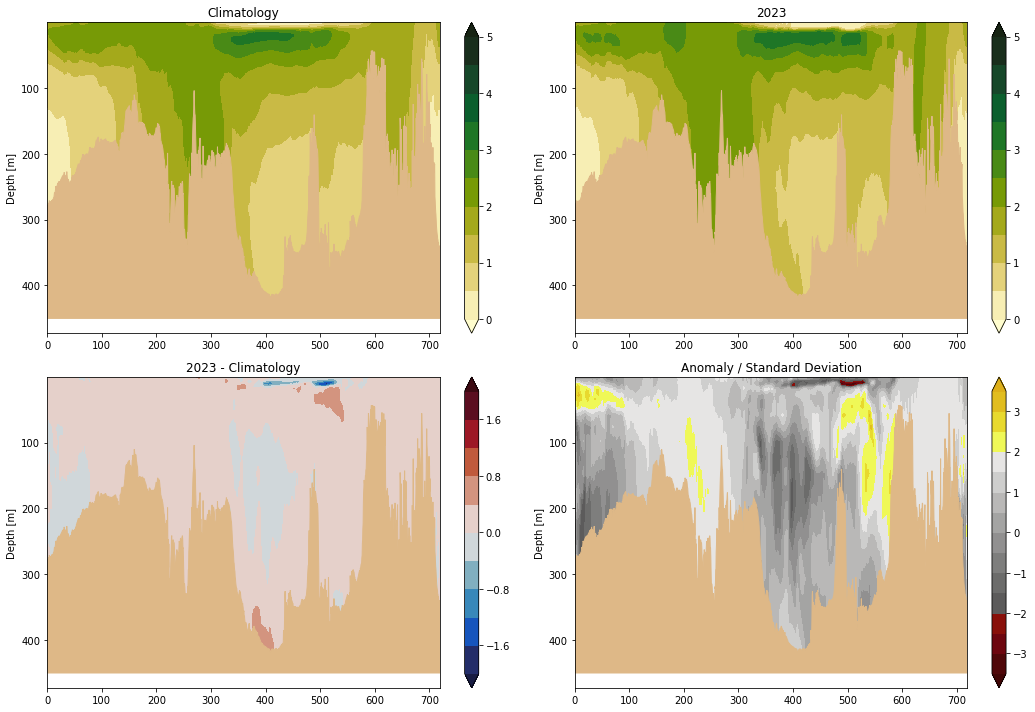

In [137]:
tracer = 'ammonium'
file = 'biol'
cmap = cm.speed
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

Ammonium is low at Chl Max depth and high below.

### dissolved Silicon ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
16.494503 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


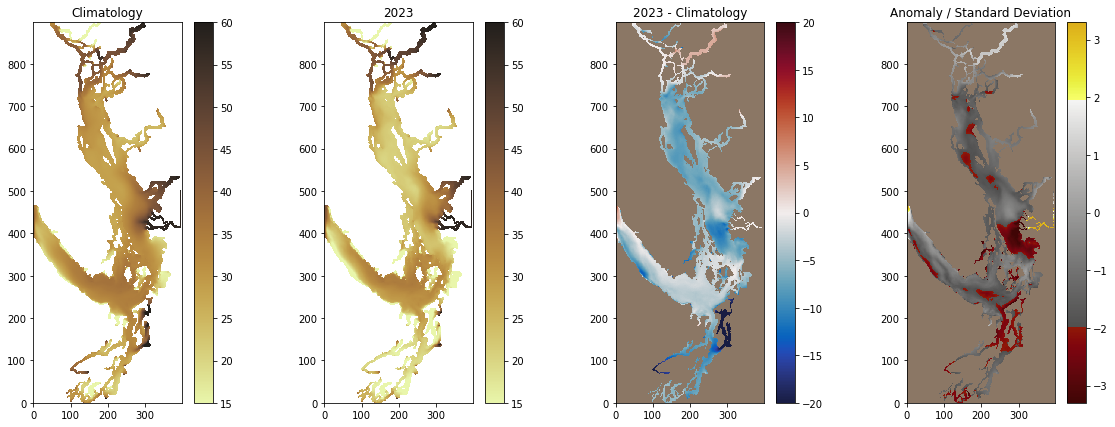

In [50]:
tracer = 'silicon'
file = 'biol'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 15
dvmax = 20
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, )

Dissolved silicon is very low, especially in southern SoG and northern Puget Sound. Not limiting though.

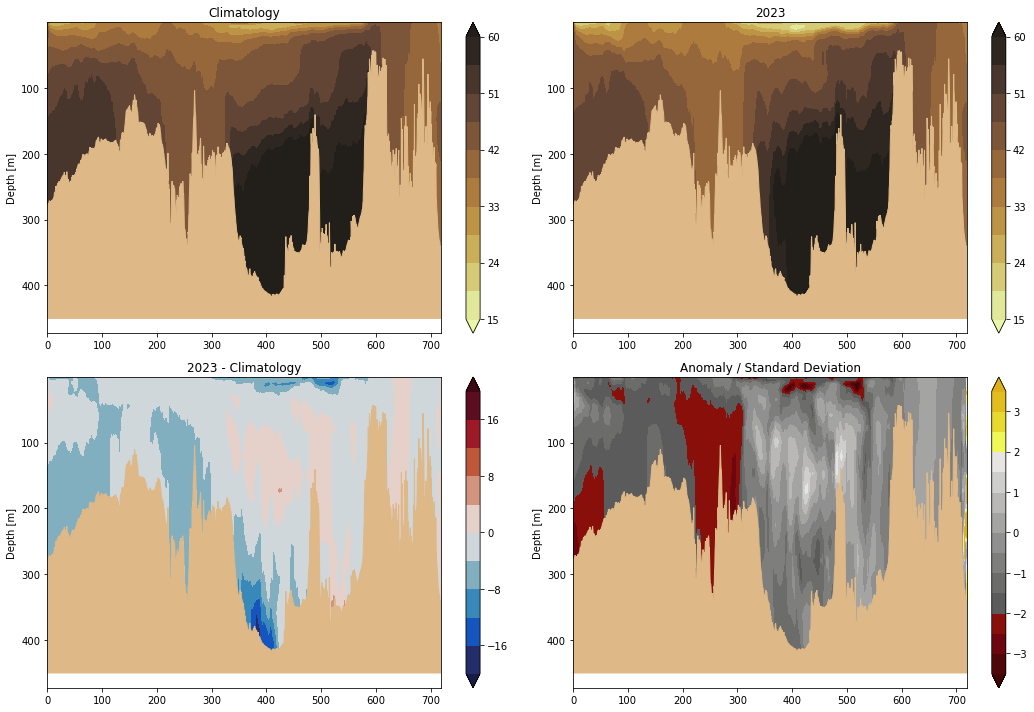

In [138]:
tracer = 'silicon'
file = 'biol'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 15
dvmax = 20
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

Silicon boundary conditions have changed.  Low dSi at Chl Max depth.

### Dissolved Oxygen ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
40.420254 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


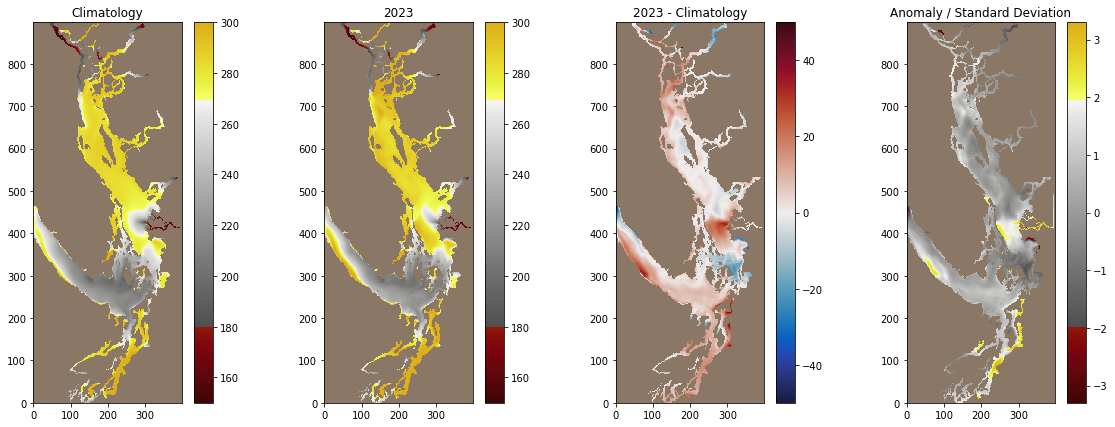

In [52]:
tracer = 'dissolved_oxygen'
file = 'chem'
cmap = cm.oxy
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 300
vmin = 150
dvmax = 50
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, )

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
59.74884 15 16


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


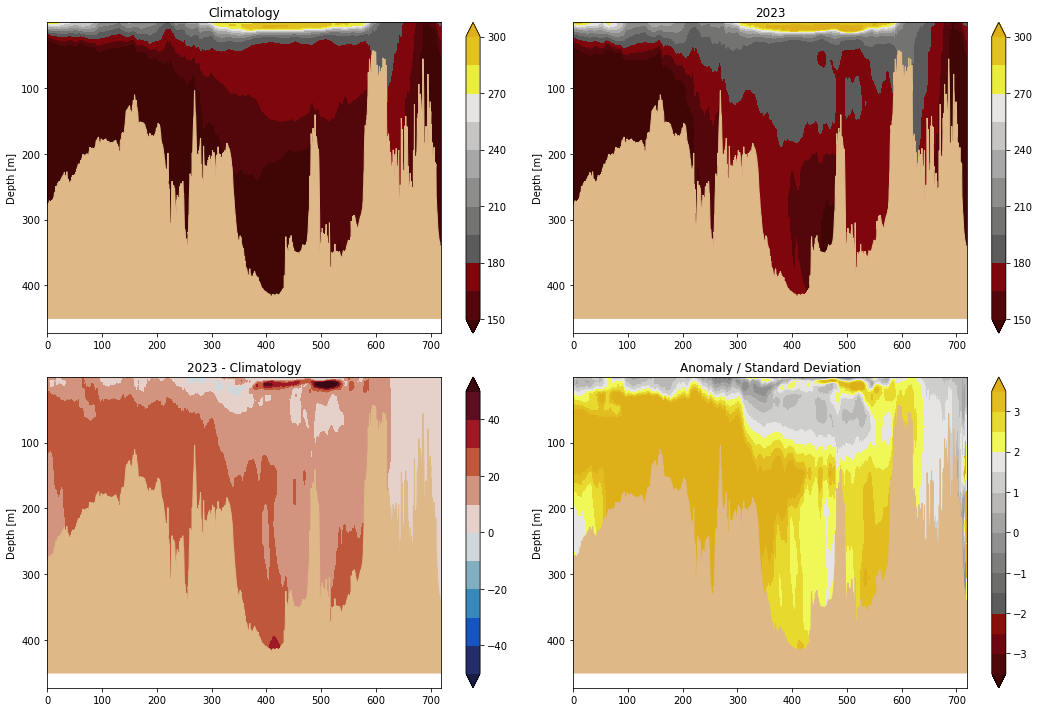

In [140]:
tracer = 'dissolved_oxygen'
file = 'chem'
cmap = cm.oxy
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 300
vmin = 150
dvmax = 50
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

Greatly changed oxygen boundary conditions.

### Dissolved Organic Nitrogen ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
1.2471128 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


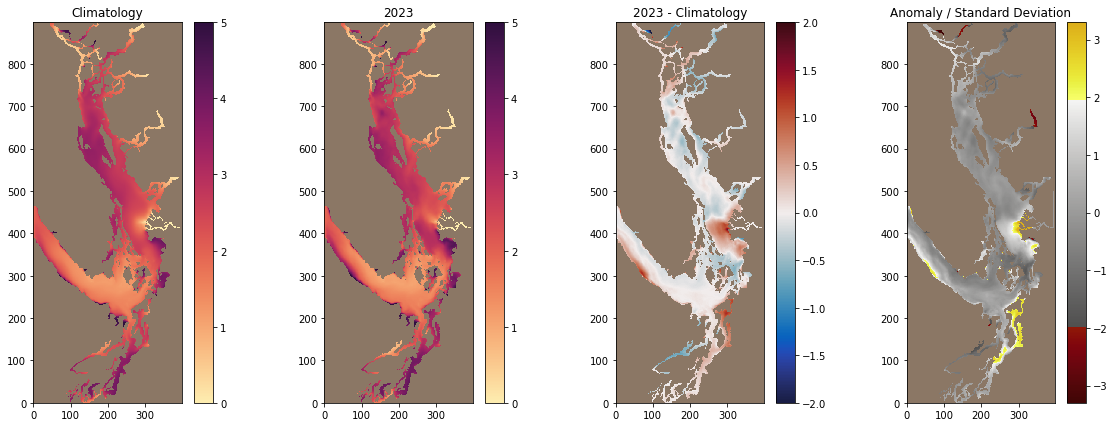

In [141]:
tracer = 'dissolved_organic_nitrogen'
file = 'biol'
cmap = cm.matter
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
1.3401071 15 16


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


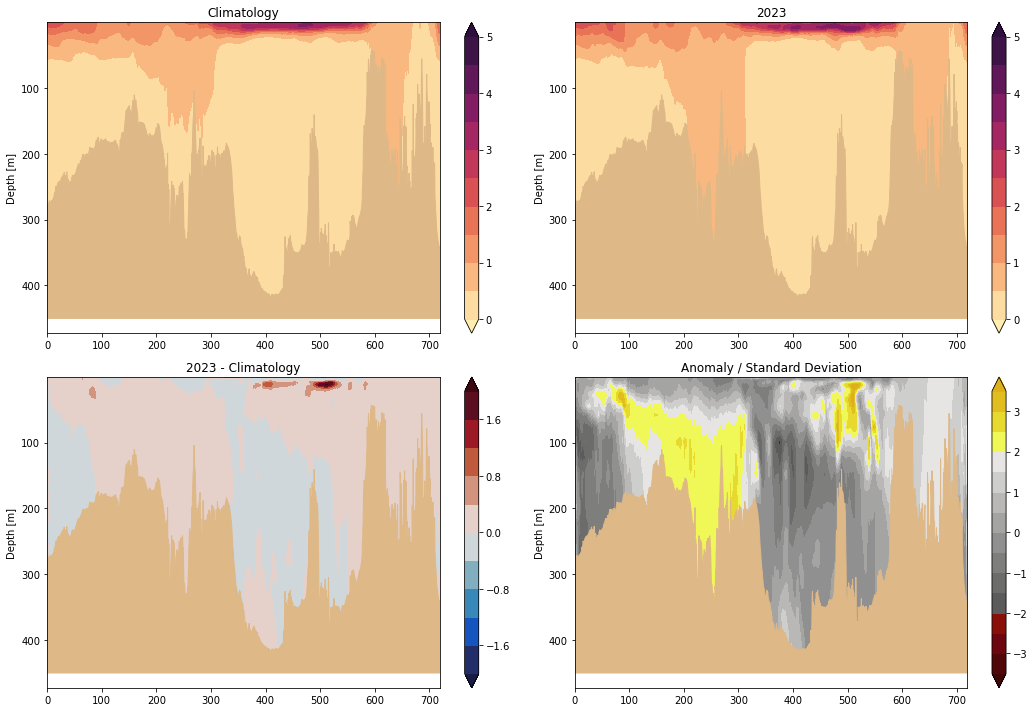

In [142]:
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

### Diatoms ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
16.92603 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


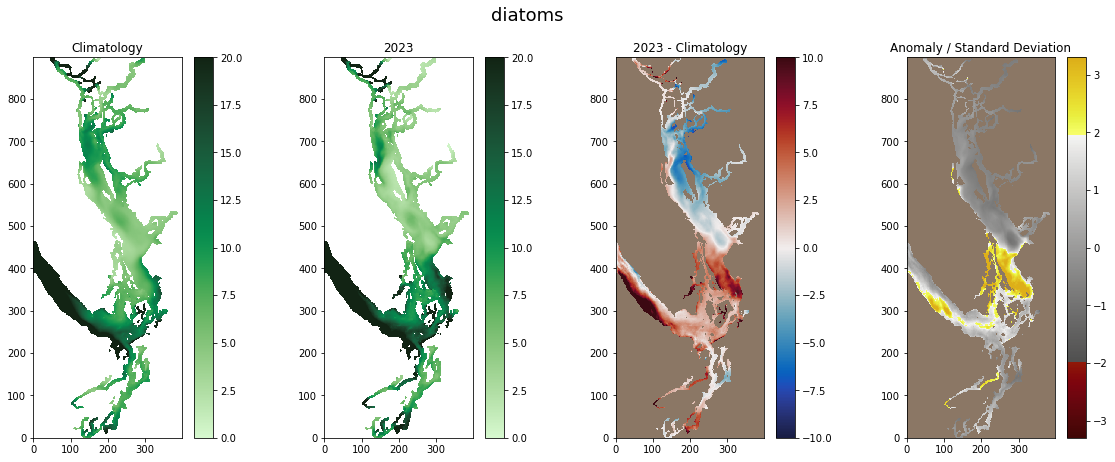

In [171]:
tracer = 'diatoms'
file = 'biol'
cmap = cm.algae
cdiff = cm.balance
vmax = 20
vmin = 0
dvmax = 10
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, dl=20, dosum=True, new=True)

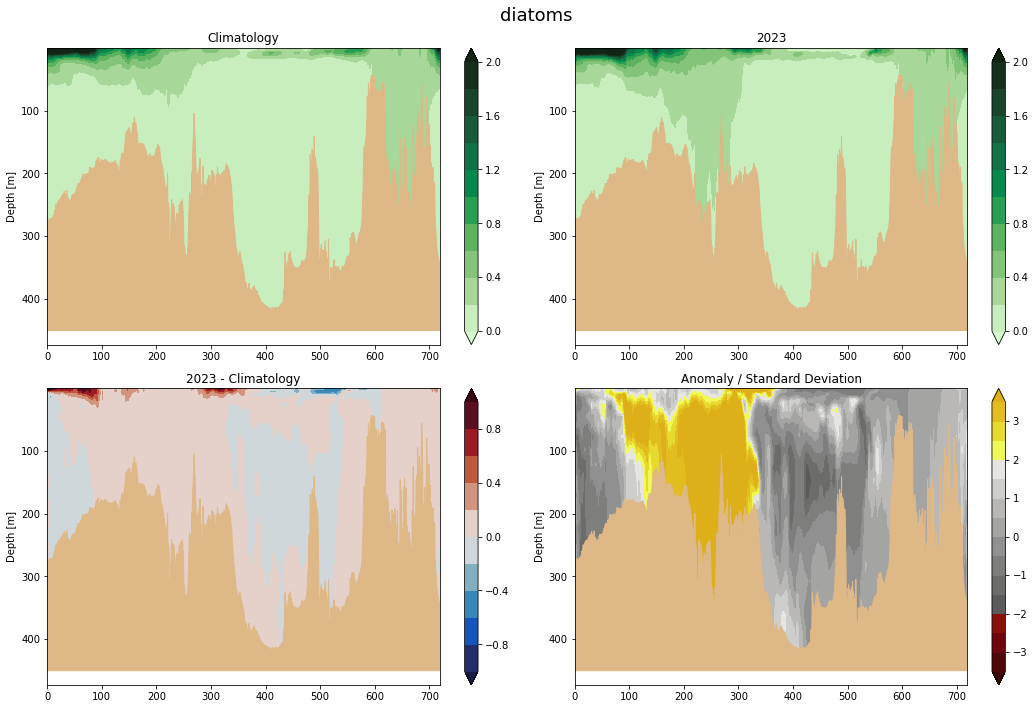

In [172]:
tracer = 'diatoms'
file = 'biol'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

### Flagellates ###

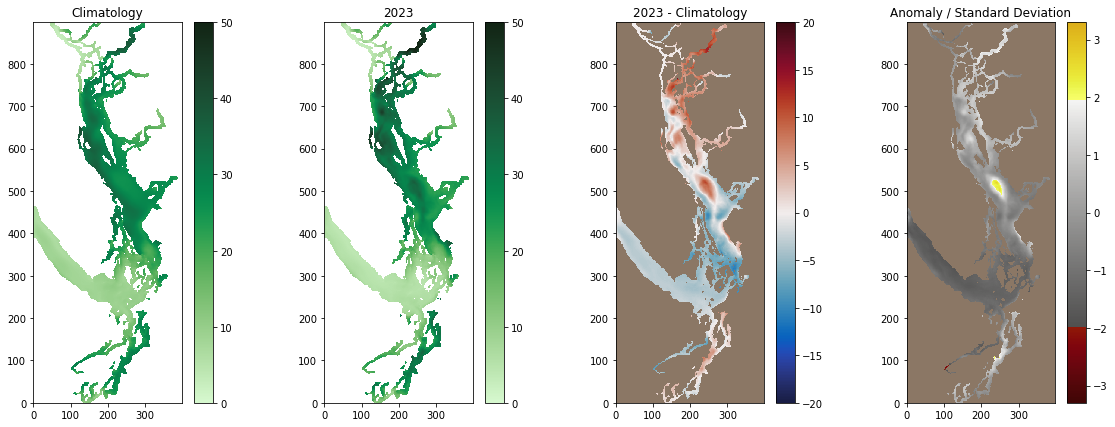

In [80]:
tracer = 'flagellates'
file = 'biol'
cmap = cm.algae
cdiff = cm.balance
vmax = 50
vmin = 0
dvmax = 20
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, dl=20, dosum=True, new=False)

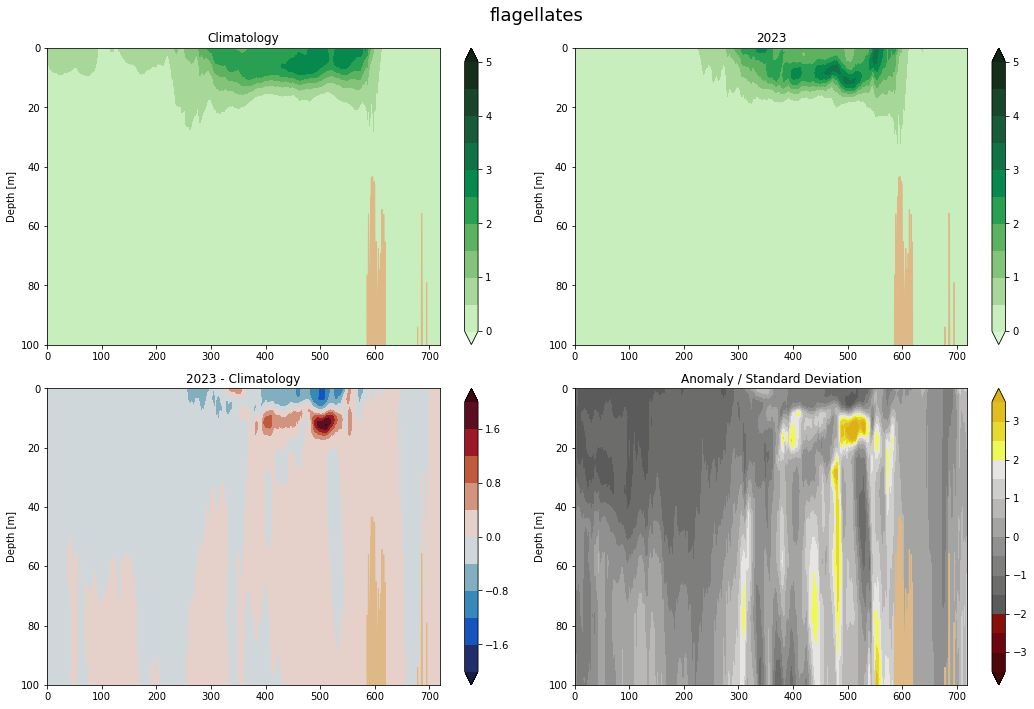

In [173]:
tracer = 'flagellates'
file = 'biol'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, maxdepth=100, new=False)

Significantly deeper Chl max to the north.

### Particulate Organic Nitrate ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
0.25979173 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


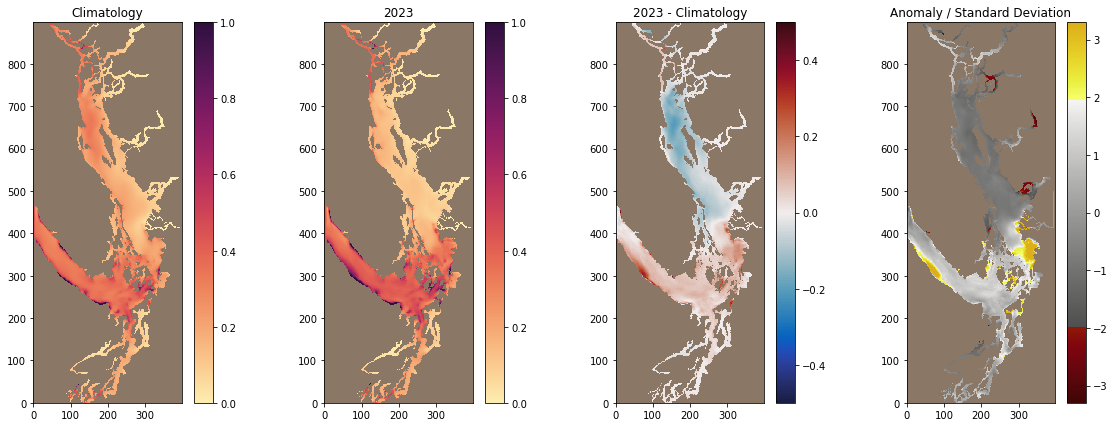

In [82]:
tracer = 'particulate_organic_nitrogen'
file = 'biol'
cmap = cm.matter
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
0.55507505 15 16


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


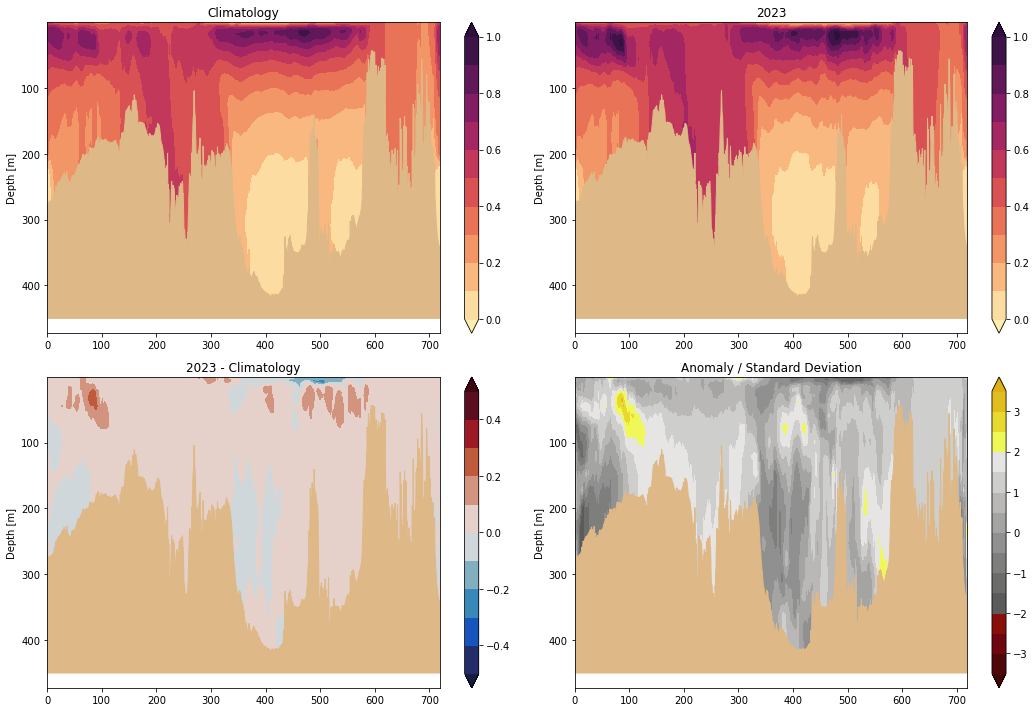

In [146]:
tracer = 'particulate_organic_nitrogen'
file = 'biol'
cmap = cm.matter
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.5
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

### Microzooplankton ###

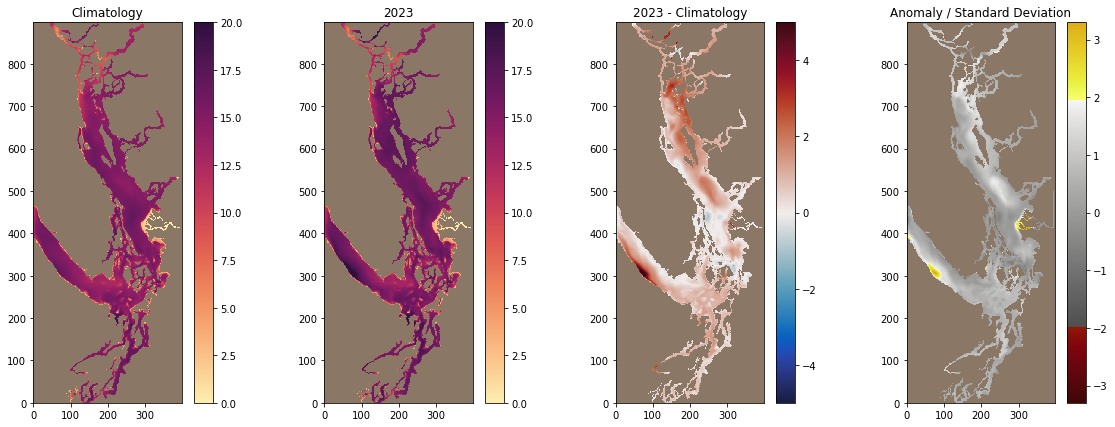

In [158]:
tracer = 'microzooplankton'
file = 'biol'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 20
vmin = 0
dvmax = 5
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, dl=39, dosum=True, new=False, surface_mask=True)

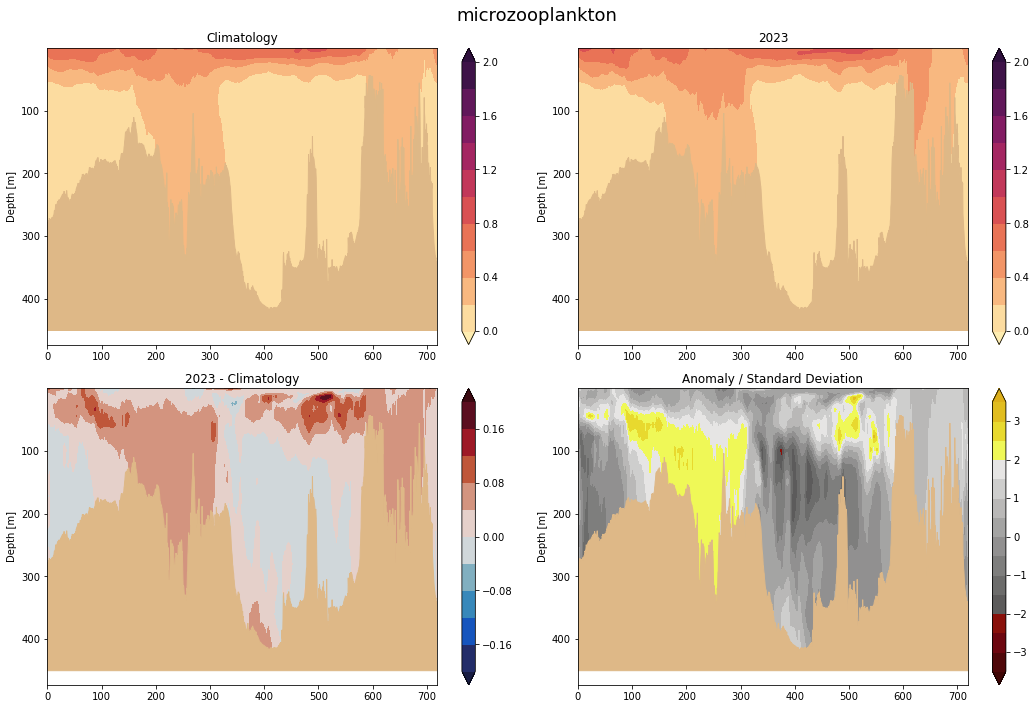

In [174]:
tracer = 'microzooplankton'
file = 'biol'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 2
vmin = 0
dvmax = 0.2
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

### Mesozooplankton ###

07
08
09
10
11
12
13
14
15
16
17
17
18
19
20
21
22
23


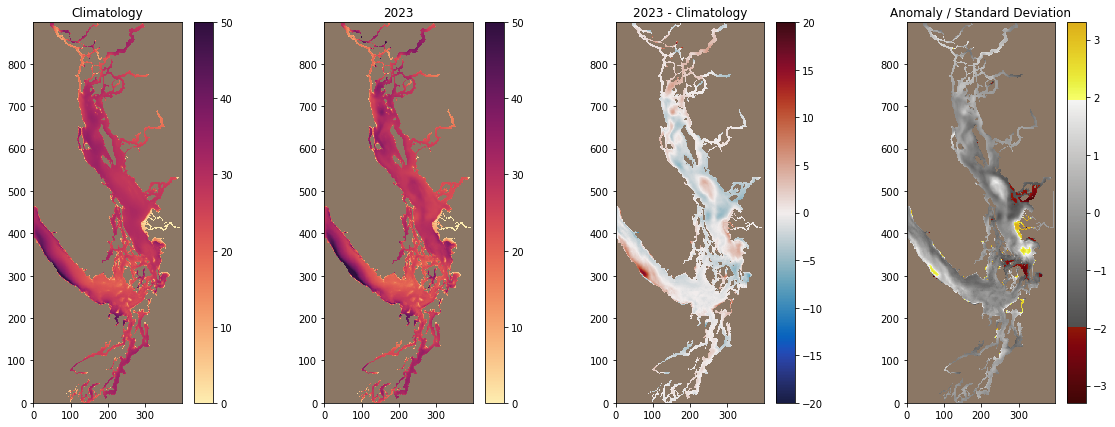

In [155]:
tracer = 'mesozooplankton'
file = 'biol'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Mesozooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Mesozooplankton (uM N)'
vmax = 50
vmin = 0
dvmax = 20
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, dl=39, dosum=True, new=True, surface_mask=True)

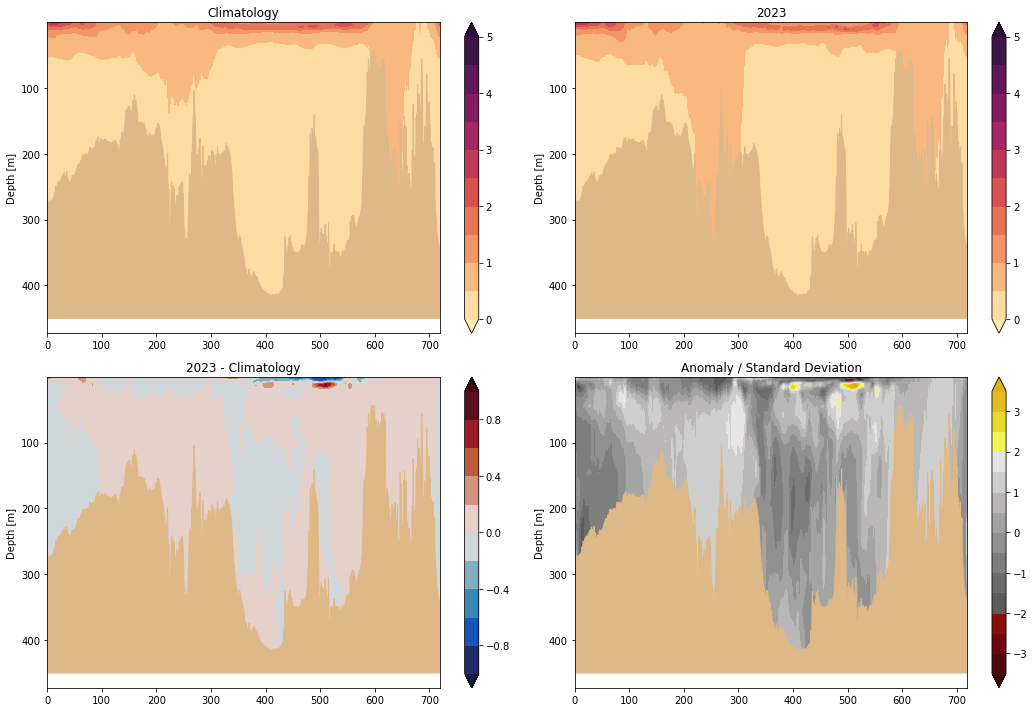

In [156]:
tracer = 'mesozooplankton'
file = 'biol'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Mesozooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Mesozooplankton (uM N)'
vmax = 5
vmin = 0
dvmax = 1
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

### Dissolved Inorganic Carbon ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
192.59998 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


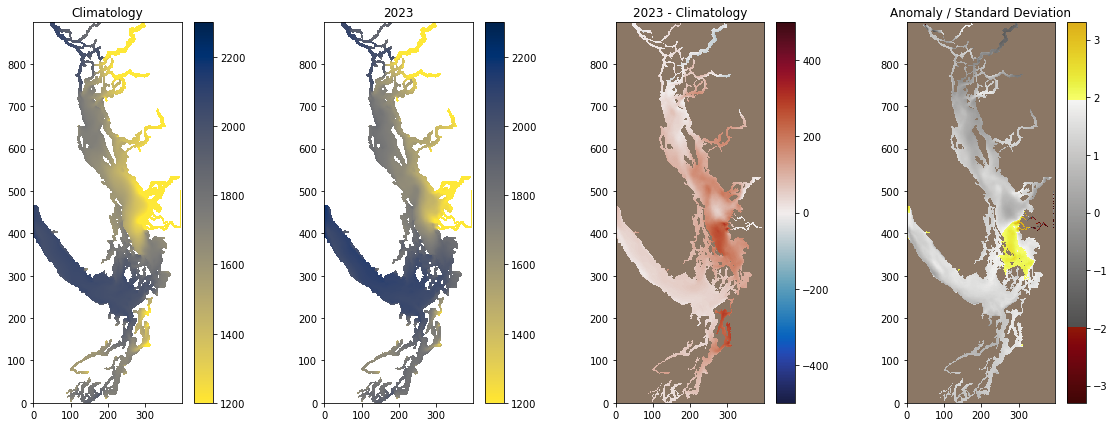

In [106]:
tracer = 'dissolved_inorganic_carbon'
file = 'chem'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2300
vmin = 1200
dvmax = 500
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

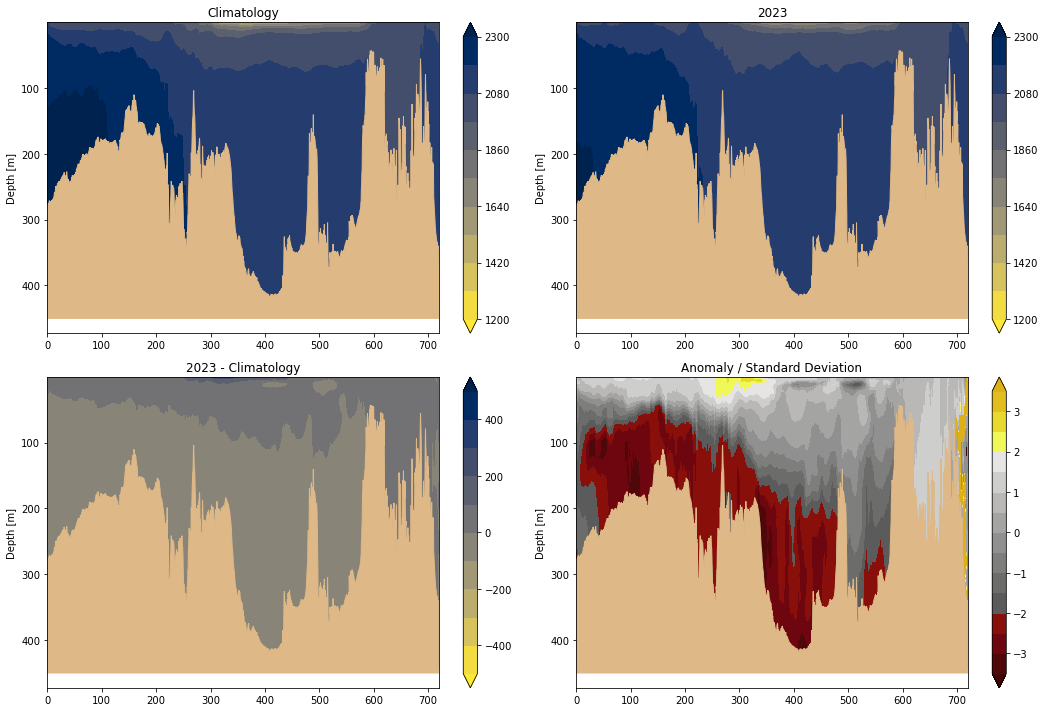

In [110]:
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=False)

### Alkalinity ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
235.11699 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


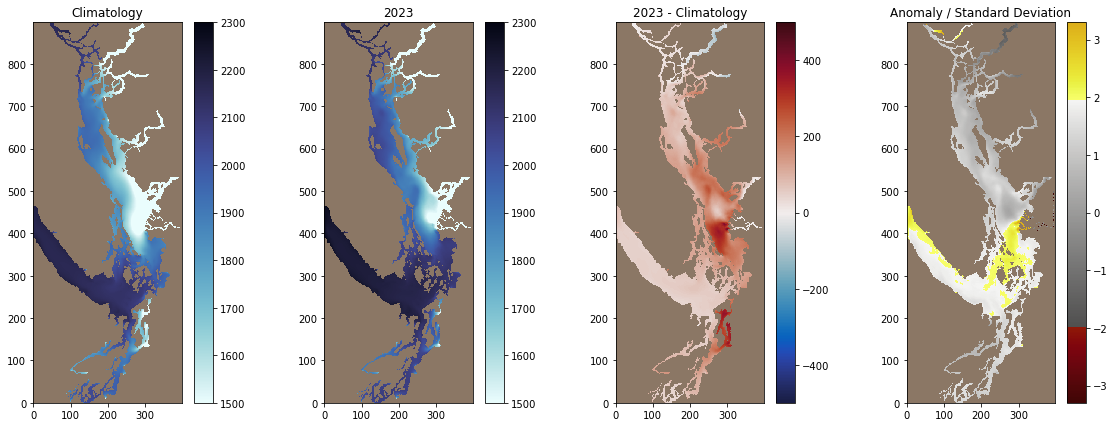

In [112]:
tracer = 'total_alkalinity'
file = 'chem'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1500
dvmax = 500
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True )

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
405.32425 15 16


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/visualisations.py:225: UserWarning: Warning: converting a masked element to nan.
  newvar[level, i] = variable[level-1, i]


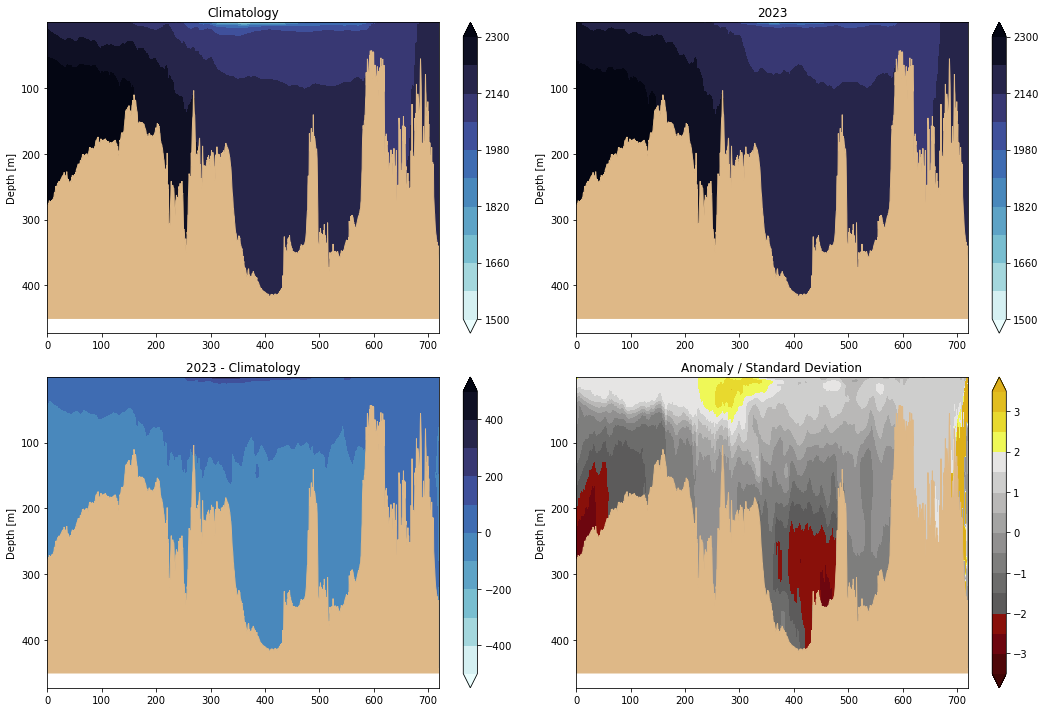

In [114]:
fig = thalweg_plot_n_save(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True)

### Fraser Tracer ###

07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
15.521741 15 16
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


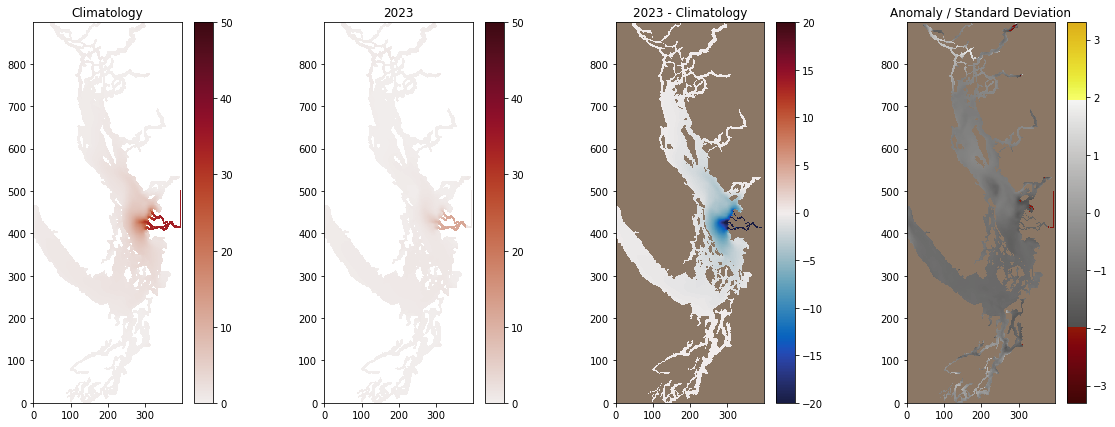

In [115]:
tracer = 'turbidity'
file = 'chem'
cmap = cm.amp
cdiff = cm.balance
vmax = 50
vmin = 0
dvmax = 20
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, new=True
                    )